# Environment Setup

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/ANNDL/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/ANNDL/[2024-2025] AN2DL/Homework 2


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from scipy.ndimage import distance_transform_edt

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras import ops
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.17.1


In [17]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 100

# Set data split size for training and validation
SPLITS_SIZE = 400

# Load data paths

In [3]:
print("Loading file paths...")
image_paths = sorted([os.path.join('data', f) for f in os.listdir('data')])
label_paths = sorted([os.path.join('labels', f) for f in os.listdir('labels')])
print("File paths loaded!")

# Display some examples of paths
print("\nFirst 5 image paths:", image_paths[:5])
print("First 5 label paths:", label_paths[:5])

Loading file paths...
File paths loaded!

First 5 image paths: ['data/image_0.png', 'data/image_1.png', 'data/image_10.png', 'data/image_100.png', 'data/image_1000.png']
First 5 label paths: ['labels/label_0.png', 'labels/label_1.png', 'labels/label_10.png', 'labels/label_100.png', 'labels/label_1000.png']


In [13]:
category_map={
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
}

In [5]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [6]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure single channel
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32)

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

# Augmentation and data loading
The augmentations include:

* Horizontal and Vertical Flip: The image and mask are randomly flipped either horizontally or vertically.
* Random Rotation: The image and mask are rotated by 90 degrees with a random factor.
* Random Zoom: The image and mask are randomly zoomed in or out, resizing them to a new scale before returning them to the original size.

In [ ]:
def augmenter(image, mask):
    # Randomly flip the image and mask horizontally
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Randomly flip the image and mask vertically
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation
    if tf.random.uniform(()) > 0.5:
        r = int(tf.random.uniform((), minval=0, maxval=1, dtype=tf.int32))
        image = tf.image.rot90(image, k = 2*r)
        mask = tf.image.rot90(mask, k= 2*r)

    # Random zoom
    if tf.random.uniform(()) > 0.5:
        scales = list(np.arange(0.8, 1.0, 0.05))
        scale = random.choice(scales)
        image_shape = tf.shape(image)
        h, w = 64, 128
        new_h = tf.maximum(1, tf.cast(h * scale, tf.int32))
        new_w = tf.maximum(1, tf.cast(w * scale, tf.int32))
        image = tf.image.resize(image, (new_h, new_w))
        mask = tf.image.resize(mask, (new_h, new_w))

        # Resize back to original size
        image = tf.image.resize_with_crop_or_pad(image, h, w)
        mask = tf.image.resize_with_crop_or_pad(mask, h, w)
        mask = tf.cast(mask, tf.int32)
    return image, mask

In [52]:
def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    image = tf_image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf_image.resize(images=image, size=[64, 128])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    mask = tf.cast(mask, tf.int32)
    image, mask = augmenter(image, mask)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_img, train_lbl)
val_dataset = data_generator(val_img, val_lbl)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(32, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, None, None, 1), dtype=tf.int32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(32, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(32, None, None, 1), dtype=tf.int32, name=None))>


In [18]:
train_img, val_img, train_lbl, val_lbl = train_test_split(
    image_paths, label_paths, test_size=SPLITS_SIZE, random_state=seed
)

In [19]:
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)
val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Visualizing examples from the training set:


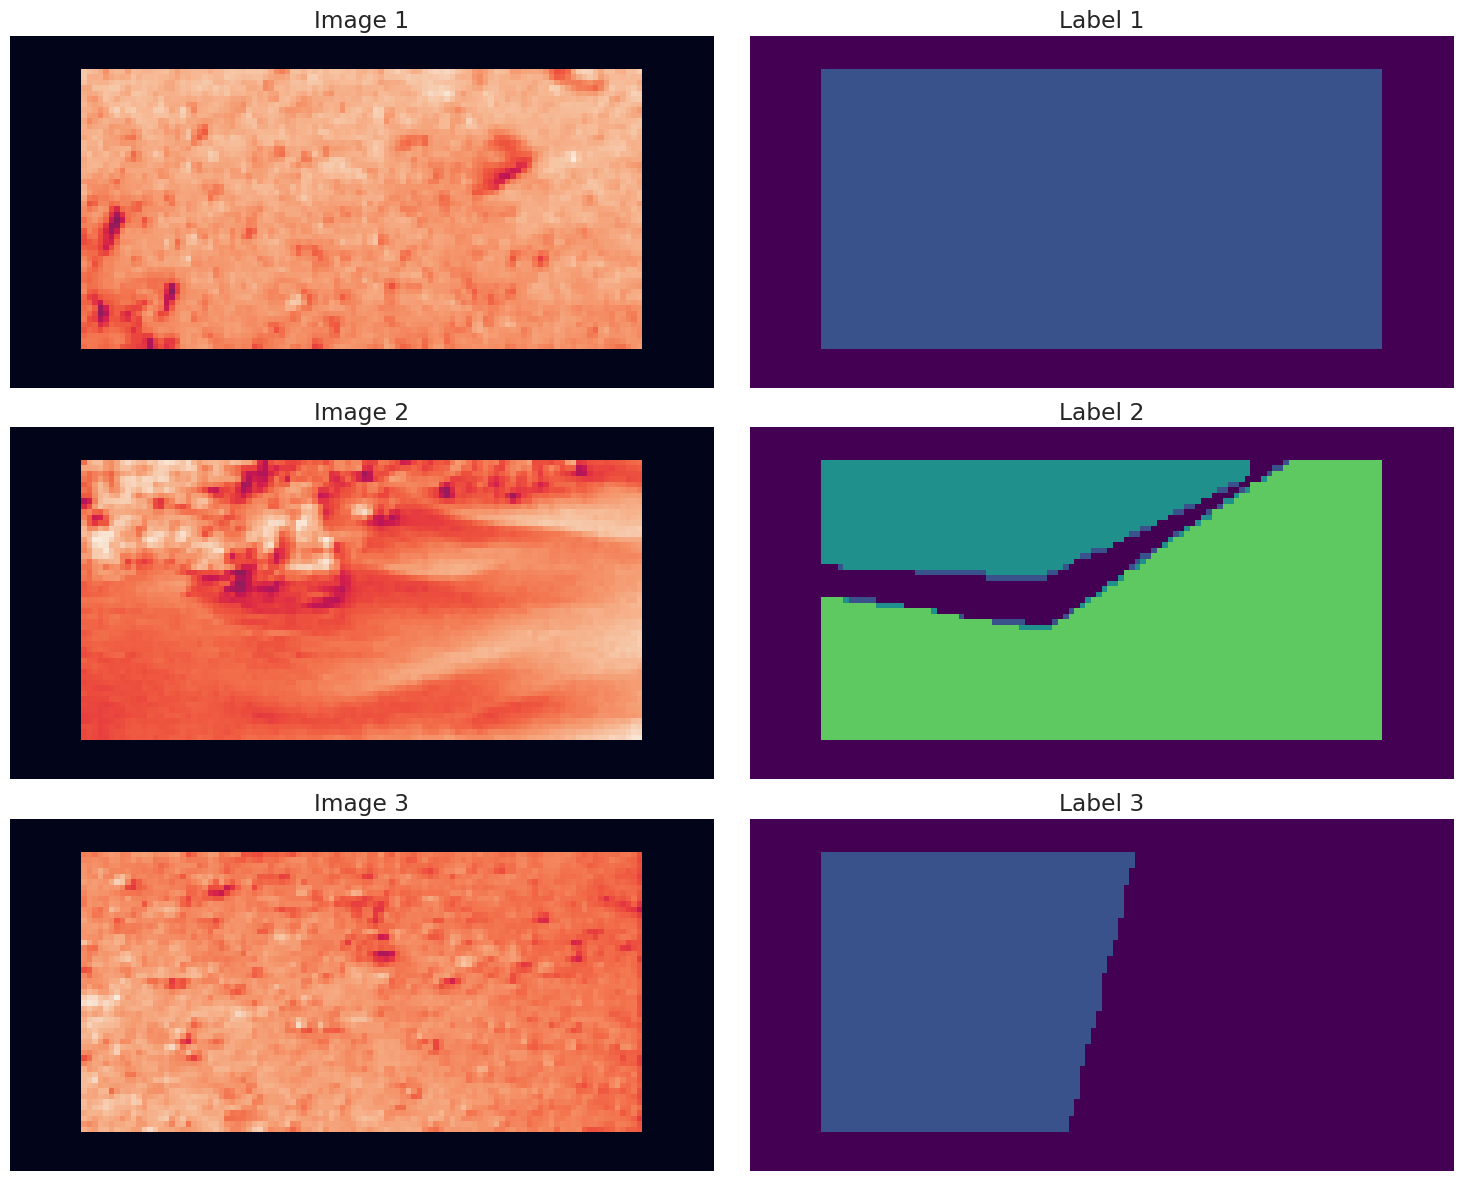

In [23]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=10)

# Model

This is a DeepLabV3+ architecture for semantic segmentation:

* Convolution Block: A basic block with convolution, batch normalization, and ReLU activation.
* Dilated Spatial Pyramid Pooling (DSPP): Applies convolutions with different dilation rates and pooling for multi-scale feature extraction.
* ResNet50 Backbone: Uses ResNet50 for feature extraction, with added DSPP for multi-scale context.
* Skip Connections: Combines features from different ResNet50 layers for better segmentation.
* Upsampling and Prediction: Upsamples features and applies a final convolution layer with softmax activation for class prediction.

The model handles grayscale input (1 channel) and outputs multi-class segmentation (5 classes).

In [60]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(input_shape, num_classes):
    model_input = keras.Input(shape=input_shape)

    # Grayscale image handling
    if input_shape[-1] == 1:
        model_input_rgb = layers.Conv2D(3, kernel_size=(1, 1), padding="same", activation=None)(model_input)
    else:
        model_input_rgb = model_input

    preprocessed = keras.applications.resnet50.preprocess_input(model_input_rgb)
    resnet50 = keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=preprocessed
    )

    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(input_shape[0] // 4 // x.shape[1], input_shape[1] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="softmax")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


In [87]:
# Model building
input_shape = (64, 128, 1)  # Grayscale input
num_classes = 5
model = DeeplabV3Plus(input_shape, num_classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_7          │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_77 (Conv2D)     │ (None, 64, 128, 3)   │            6 │ input_layer_7[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_21 (GetItem)  │ (None, 64, 128)      │            0 │ conv2d_77[0][0]     │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_22 (GetItem)  │ (None, 64, 128)      │            0 │ conv2d_77[0][0]     │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ get_item_23 (GetItem)  │ (None, 64, 128)      │            0 │ conv2d_77[0][0]     │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ stack_8 (Stack)        │ (None, 64, 128, 3)   │            0 │ get_item_21[0][0],  │    -    │
│                        │                      │              │ get_item_22[0][0],  │         │
│                        │                      │              │ get_item_23[0][0]   │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add_7 (Add)            │ (None, 64, 128, 3)   │            0 │ stack_8[0][0]       │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_pad              │ (None, 70, 134, 3)   │            0 │ add_7[0][0]         │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_conv (Conv2D)    │ (None, 32, 64, 64)   │        9,472 │ conv1_pad[0][0]     │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_bn               │ (None, 32, 64, 64)   │          256 │ conv1_conv[0][0]    │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_relu             │ (None, 32, 64, 64)   │            0 │ conv1_bn[0][0]      │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pad              │ (None, 34, 66, 64)   │            0 │ conv1_relu[0][0]    │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pool             │ (None, 16, 32, 64)   │            0 │ pool1_pad[0][0]     │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_conv    │ (None, 16, 32, 64)   │        4,160 │ pool1_pool[0][0]    │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_bn      │ (None, 16, 32, 64)   │          256 │ conv2_block1_1_con… │    Y    │
│ (BatchNormalization) 

 Total params: 11,853,387 (45.22 MB)

 Trainable params: 11,820,651 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

# Model Training
* Custom Metrics: A MeanIntersectionOverUnion metric is defined to compute IoU, excluding specific classes (default is class 0).
* Focal Loss: A custom focal loss is used, applying class weights based on dataset distribution to focus on underrepresented classes.
* Visualization: A callback visualizes input images, ground truth, and predictions every few epochs to monitor progress.
* Model Training: The model is compiled with focal loss, an AdamW optimizer, and custom metrics. Training uses early stopping, and the model is saved with the final accuracy.

In [61]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [62]:
@tf.keras.utils.register_keras_serializable(package="Custom")
def focal_loss(y_true, y_pred, class_weight=None, gamma=2., alpha=0.25):
    # Calcola l'entropia incrociata
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Se sono forniti pesi per le classi, applicali
    if class_weight is not None:
        y_true = tf.cast(y_true, tf.int32)
        weights = tf.gather(class_weight, y_true)  # Estrai i pesi in base alle etichette vere

        weights = tf.squeeze(weights, axis=-1)
        cross_entropy = cross_entropy * weights

    # Calcola la perdita focalizzata
    loss = alpha * tf.pow(1 - cross_entropy, gamma)
    return tf.reduce_mean(loss)

In [63]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[1], val_lbl[1])

These class weights are derived from the percentage of images in the dataset with at least one pixel of the corresponding class.


1.   0.380 -> 2.63
2.   0.345 -> 2.90
3.   0.256 -> 3.91
4.   0.0187 -> 53.48

In [64]:
# Definition of class weights
class_weights = {0: 0, 1: 2.63, 2: 2.90, 3: 3.91, 4: 53.48}

# Compiling the model
print("Compiling model...")
model.compile(
    loss=lambda y_true, y_pred: focal_loss(y_true, y_pred, class_weight=tf.constant(list(class_weights.values()))),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])],
)
print("Model compiled!")

Compiling model...
Model compiled!


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 14.3501 - mean_iou: 0.0581 - sparse_categorical_crossentropy: 1.7363

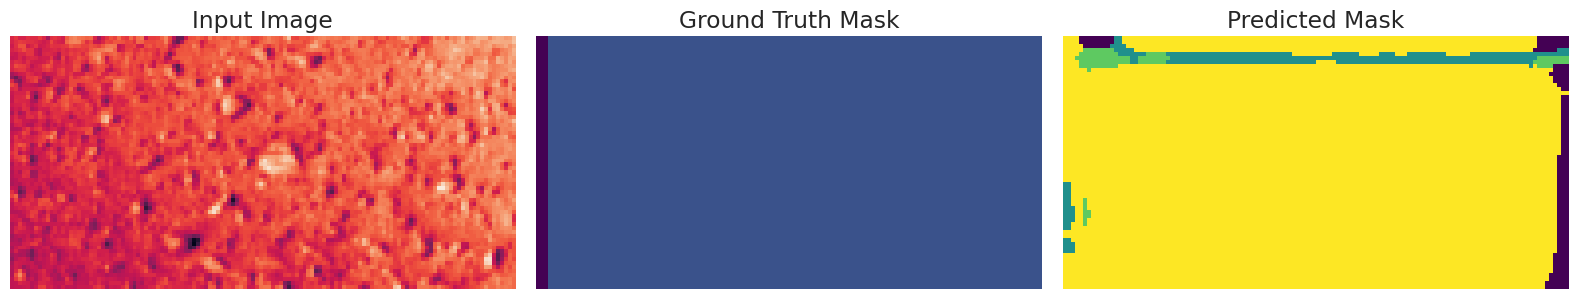

65/65 ━━━━━━━━━━━━━━━━━━━━ 73s 317ms/step - loss: 14.2529 - mean_iou: 0.0584 - sparse_categorical_crossentropy: 1.7360 - val_loss: 3.8701 - val_mean_iou: 0.0037 - val_sparse_categorical_crossentropy: 1.8663
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 5.7262 - mean_iou: 0.1228 - sparse_categorical_crossentropy: 1.6928 - val_loss: 3.1367 - val_mean_iou: 0.1203 - val_sparse_categorical_crossentropy: 1.5832
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 4.2735 - mean_iou: 0.1479 - sparse_categorical_crossentropy: 1.6572 - val_loss: 3.4371 - val_mean_iou: 0.1461 - val_sparse_categorical_crossentropy: 1.5061
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 3.5350 - mean_iou: 0.1651 - sparse_categorical_crossentropy: 1.6585 - val_loss: 3.0373 - val_mean_iou: 0.1369 - val_sparse_categorical_crossentropy: 1.5664
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 2.9602 - mean_iou: 0.1742 - sparse_categorical_crossentropy: 1.6702 - val_los

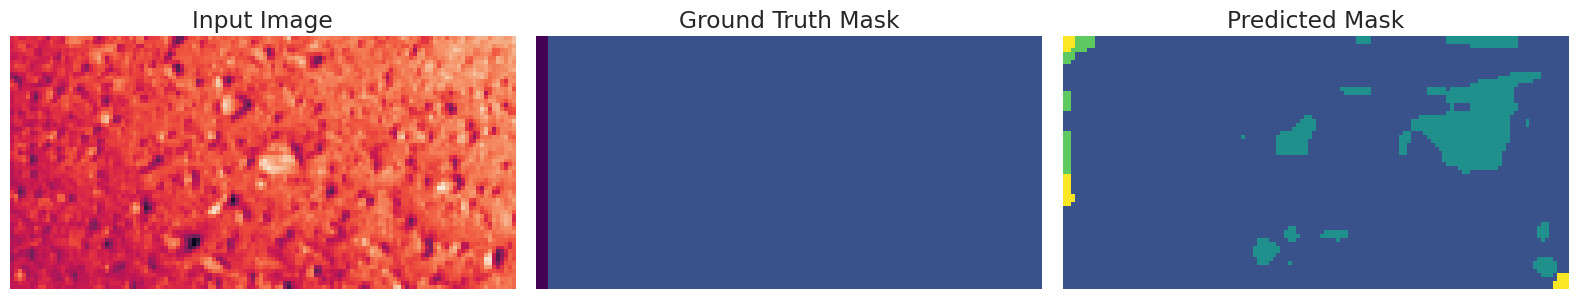

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 2.7724 - mean_iou: 0.1851 - sparse_categorical_crossentropy: 1.6982 - val_loss: 2.4948 - val_mean_iou: 0.1794 - val_sparse_categorical_crossentropy: 1.8051
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 2.3995 - mean_iou: 0.1930 - sparse_categorical_crossentropy: 1.7169 - val_loss: 4.4665 - val_mean_iou: 0.1685 - val_sparse_categorical_crossentropy: 2.2320
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 2.8609 - mean_iou: 0.1962 - sparse_categorical_crossentropy: 1.7083 - val_loss: 3.4072 - val_mean_iou: 0.1614 - val_sparse_categorical_crossentropy: 2.1369
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 2.2251 - mean_iou: 0.2037 - sparse_categorical_crossentropy: 1.7078 - val_loss: 2.8769 - val_mean_iou: 0.1501 - val_sparse_categorical_crossentropy: 2.2812
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 2.5078 - mean_iou: 0.1972 - sparse_categorical_crossentropy: 1.7580 - val_los

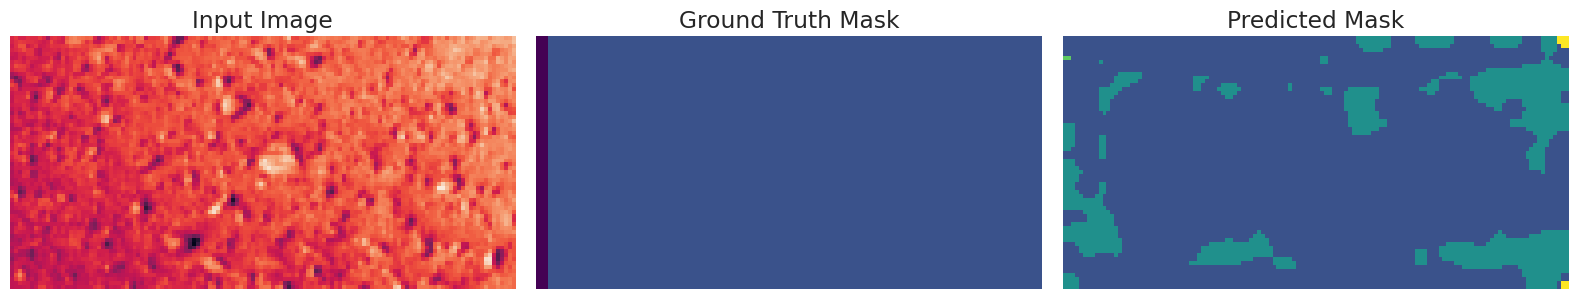

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 1.9771 - mean_iou: 0.2144 - sparse_categorical_crossentropy: 1.7388 - val_loss: 2.6826 - val_mean_iou: 0.1916 - val_sparse_categorical_crossentropy: 2.1771
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - loss: 1.8443 - mean_iou: 0.2252 - sparse_categorical_crossentropy: 1.7615 - val_loss: 3.3037 - val_mean_iou: 0.1956 - val_sparse_categorical_crossentropy: 2.4649
Epoch 13/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 1.7266 - mean_iou: 0.2328 - sparse_categorical_crossentropy: 1.7596 - val_loss: 2.0702 - val_mean_iou: 0.1904 - val_sparse_categorical_crossentropy: 2.1764
Epoch 14/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - loss: 1.8966 - mean_iou: 0.2198 - sparse_categorical_crossentropy: 1.8064 - val_loss: 3.6647 - val_mean_iou: 0.1552 - val_sparse_categorical_crossentropy: 2.5304
Epoch 15/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 1.7845 - mean_iou: 0.2322 - sparse_categorical_crossentropy: 1.7953 - val_

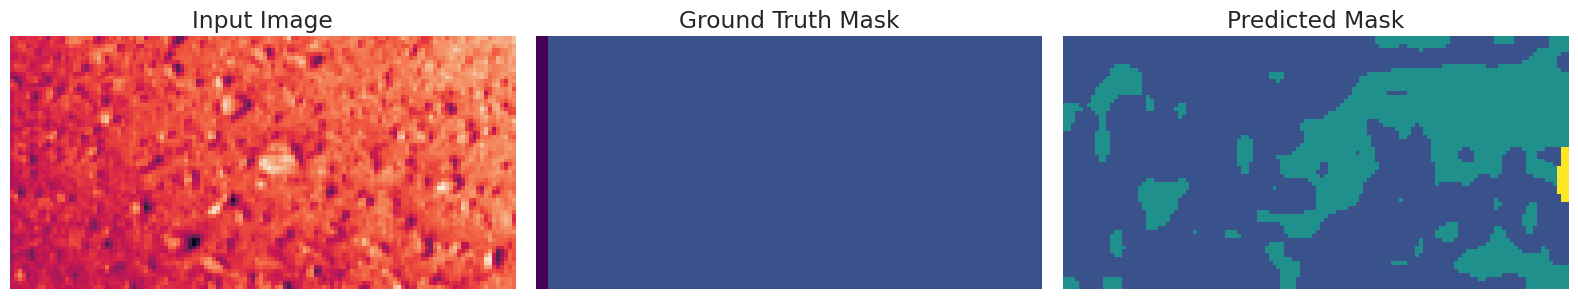

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 1.6679 - mean_iou: 0.2307 - sparse_categorical_crossentropy: 1.8343 - val_loss: 3.4626 - val_mean_iou: 0.2043 - val_sparse_categorical_crossentropy: 2.7589
Epoch 17/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.6090 - mean_iou: 0.2488 - sparse_categorical_crossentropy: 1.8278 - val_loss: 2.7037 - val_mean_iou: 0.2300 - val_sparse_categorical_crossentropy: 2.5094
Epoch 18/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 1.2863 - mean_iou: 0.2705 - sparse_categorical_crossentropy: 1.8071 - val_loss: 3.1425 - val_mean_iou: 0.1946 - val_sparse_categorical_crossentropy: 2.5359
Epoch 19/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.8431 - mean_iou: 0.3249 - sparse_categorical_crossentropy: 1.8291 - val_loss: 3.0114 - val_mean_iou: 0.2083 - val_sparse_categorical_crossentropy: 2.7970
Epoch 20/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 1.3586 - mean_iou: 0.3420 - sparse_categorical_crossentropy: 1.7856 - val_

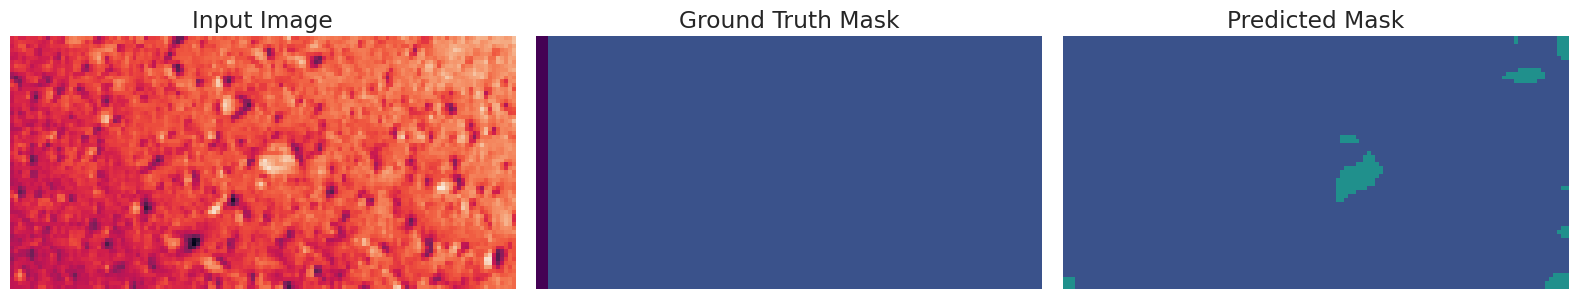

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 1.1032 - mean_iou: 0.3445 - sparse_categorical_crossentropy: 1.7999 - val_loss: 3.1320 - val_mean_iou: 0.2707 - val_sparse_categorical_crossentropy: 2.5758
Epoch 22/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.2687 - mean_iou: 0.2850 - sparse_categorical_crossentropy: 1.8185 - val_loss: 2.7569 - val_mean_iou: 0.1993 - val_sparse_categorical_crossentropy: 2.5269
Epoch 23/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 1.0663 - mean_iou: 0.2795 - sparse_categorical_crossentropy: 1.8222 - val_loss: 1.7625 - val_mean_iou: 0.2313 - val_sparse_categorical_crossentropy: 2.2296
Epoch 24/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.9485 - mean_iou: 0.3262 - sparse_categorical_crossentropy: 1.8162 - val_loss: 2.3164 - val_mean_iou: 0.2264 - val_sparse_categorical_crossentropy: 2.3286
Epoch 25/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 2.1075 - mean_iou: 0.3404 - sparse_categorical_crossentropy: 1.8992 - val_

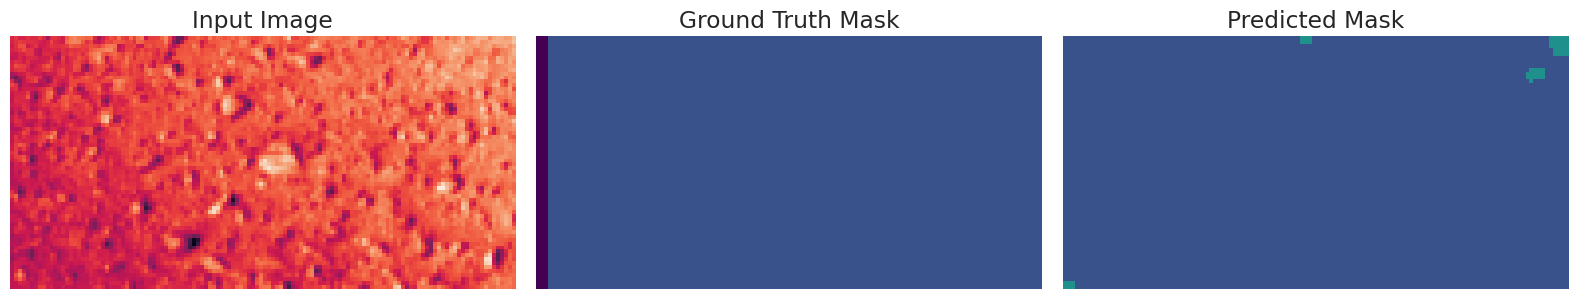

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 1.8264 - mean_iou: 0.3184 - sparse_categorical_crossentropy: 1.9157 - val_loss: 2.2423 - val_mean_iou: 0.2458 - val_sparse_categorical_crossentropy: 2.4770
Epoch 27/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.5140 - mean_iou: 0.2950 - sparse_categorical_crossentropy: 1.9406 - val_loss: 2.2125 - val_mean_iou: 0.2767 - val_sparse_categorical_crossentropy: 2.3071
Epoch 28/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.1574 - mean_iou: 0.2896 - sparse_categorical_crossentropy: 1.9322 - val_loss: 1.8907 - val_mean_iou: 0.2992 - val_sparse_categorical_crossentropy: 2.5257
Epoch 29/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.7667 - mean_iou: 0.3460 - sparse_categorical_crossentropy: 1.9328 - val_loss: 2.0241 - val_mean_iou: 0.2479 - val_sparse_categorical_crossentropy: 2.7923
Epoch 30/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.5242 - mean_iou: 0.2857 - sparse_categorical_crossentropy: 1.9570 - val_

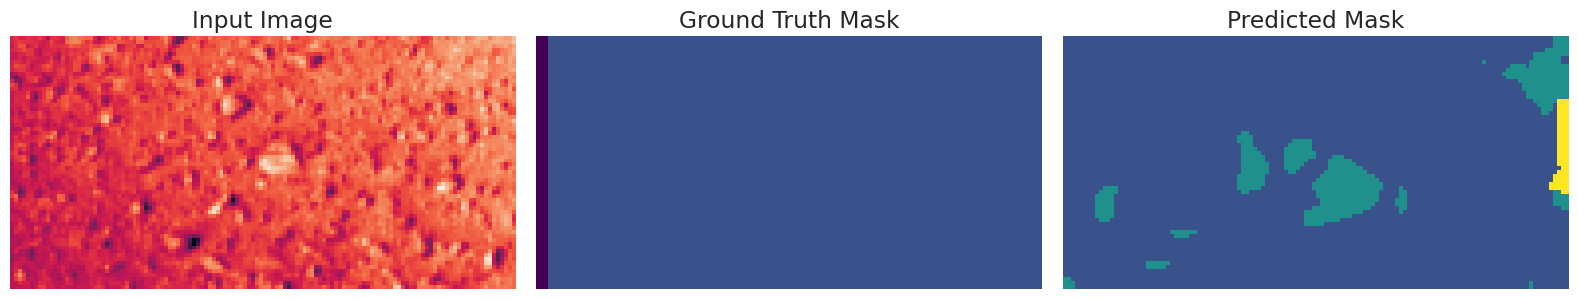

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 1.4436 - mean_iou: 0.3138 - sparse_categorical_crossentropy: 1.9777 - val_loss: 2.1724 - val_mean_iou: 0.2293 - val_sparse_categorical_crossentropy: 2.6127
Epoch 32/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.3311 - mean_iou: 0.2983 - sparse_categorical_crossentropy: 1.9332 - val_loss: 2.7792 - val_mean_iou: 0.1925 - val_sparse_categorical_crossentropy: 2.6272
Epoch 33/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.1062 - mean_iou: 0.3085 - sparse_categorical_crossentropy: 1.9189 - val_loss: 2.7674 - val_mean_iou: 0.2877 - val_sparse_categorical_crossentropy: 2.7986
Epoch 34/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.0408 - mean_iou: 0.3244 - sparse_categorical_crossentropy: 1.9296 - val_loss: 2.4608 - val_mean_iou: 0.2832 - val_sparse_categorical_crossentropy: 2.6919
Epoch 35/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.9461 - mean_iou: 0.3522 - sparse_categorical_crossentropy: 1.9476 - val_

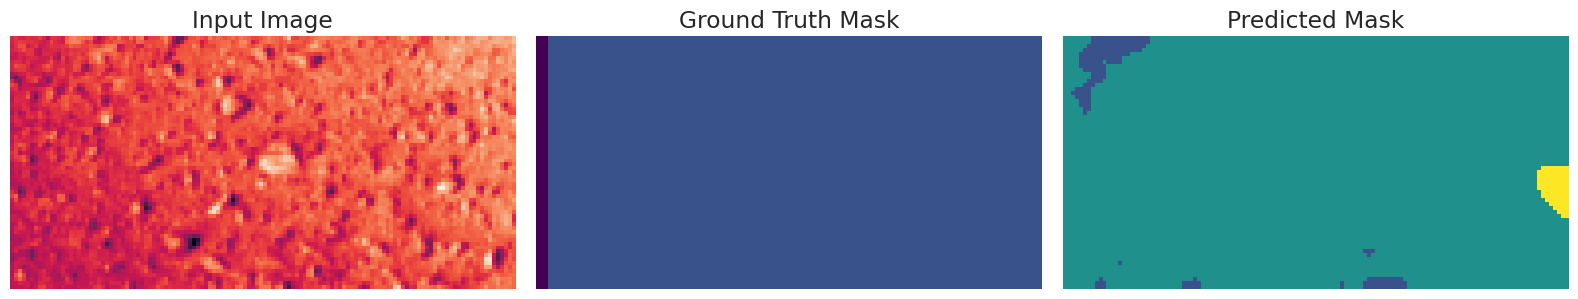

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.9571 - mean_iou: 0.3832 - sparse_categorical_crossentropy: 1.9632 - val_loss: 2.2498 - val_mean_iou: 0.2892 - val_sparse_categorical_crossentropy: 2.8182
Epoch 37/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.7694 - mean_iou: 0.4046 - sparse_categorical_crossentropy: 1.9581 - val_loss: 2.3893 - val_mean_iou: 0.3028 - val_sparse_categorical_crossentropy: 2.7158
Epoch 38/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 0.7430 - mean_iou: 0.4408 - sparse_categorical_crossentropy: 1.9485 - val_loss: 2.6059 - val_mean_iou: 0.3259 - val_sparse_categorical_crossentropy: 2.7055
Epoch 39/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.9100 - mean_iou: 0.4356 - sparse_categorical_crossentropy: 1.9487 - val_loss: 7.3628 - val_mean_iou: 0.2235 - val_sparse_categorical_crossentropy: 4.0961
Epoch 40/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.9746 - mean_iou: 0.3435 - sparse_categorical_crossentropy: 2.0065 - val_

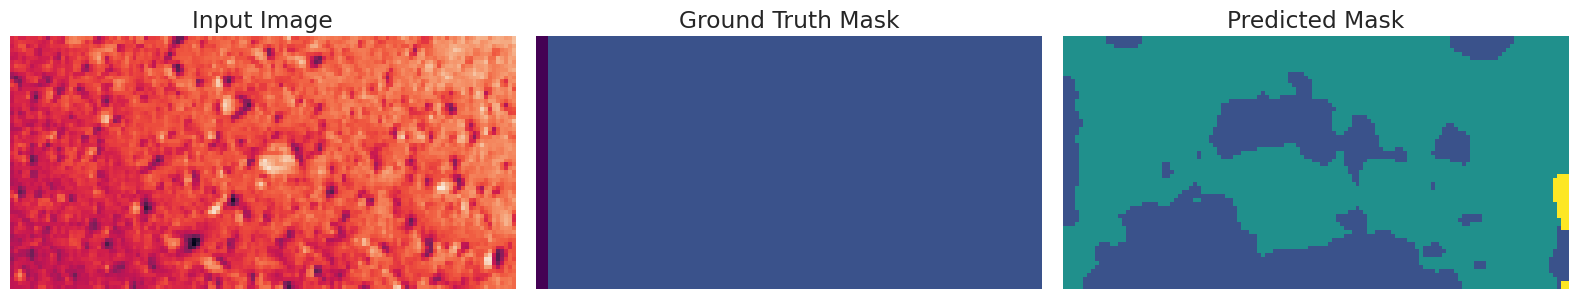

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.9344 - mean_iou: 0.3998 - sparse_categorical_crossentropy: 2.0114 - val_loss: 2.2530 - val_mean_iou: 0.2802 - val_sparse_categorical_crossentropy: 2.6794
Epoch 42/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.0166 - mean_iou: 0.4118 - sparse_categorical_crossentropy: 1.9926 - val_loss: 2.2945 - val_mean_iou: 0.2650 - val_sparse_categorical_crossentropy: 2.6284
Epoch 43/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.9226 - mean_iou: 0.4103 - sparse_categorical_crossentropy: 2.0258 - val_loss: 2.5910 - val_mean_iou: 0.2842 - val_sparse_categorical_crossentropy: 2.8287
Epoch 44/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.7627 - mean_iou: 0.4197 - sparse_categorical_crossentropy: 2.0147 - val_loss: 2.8354 - val_mean_iou: 0.2854 - val_sparse_categorical_crossentropy: 2.9719
Epoch 45/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.7960 - mean_iou: 0.4230 - sparse_categorical_crossentropy: 1.9978 - val_

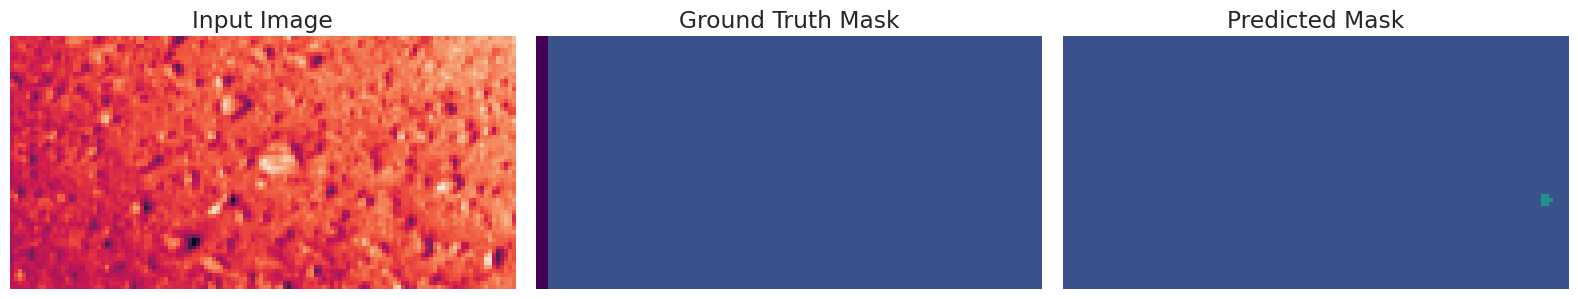

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - loss: 1.0580 - mean_iou: 0.3368 - sparse_categorical_crossentropy: 2.0457 - val_loss: 2.8567 - val_mean_iou: 0.1937 - val_sparse_categorical_crossentropy: 2.8546
Epoch 47/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.3272 - mean_iou: 0.3670 - sparse_categorical_crossentropy: 2.0675 - val_loss: 2.5557 - val_mean_iou: 0.2719 - val_sparse_categorical_crossentropy: 2.9352
Epoch 48/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.0396 - mean_iou: 0.3137 - sparse_categorical_crossentropy: 2.0557 - val_loss: 2.3063 - val_mean_iou: 0.2367 - val_sparse_categorical_crossentropy: 3.0687
Epoch 49/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.7454 - mean_iou: 0.4218 - sparse_categorical_crossentropy: 2.0447 - val_loss: 1.9221 - val_mean_iou: 0.2731 - val_sparse_categorical_crossentropy: 2.7409
Epoch 50/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.8127 - mean_iou: 0.4076 - sparse_categorical_crossentropy: 2.0660 - val_

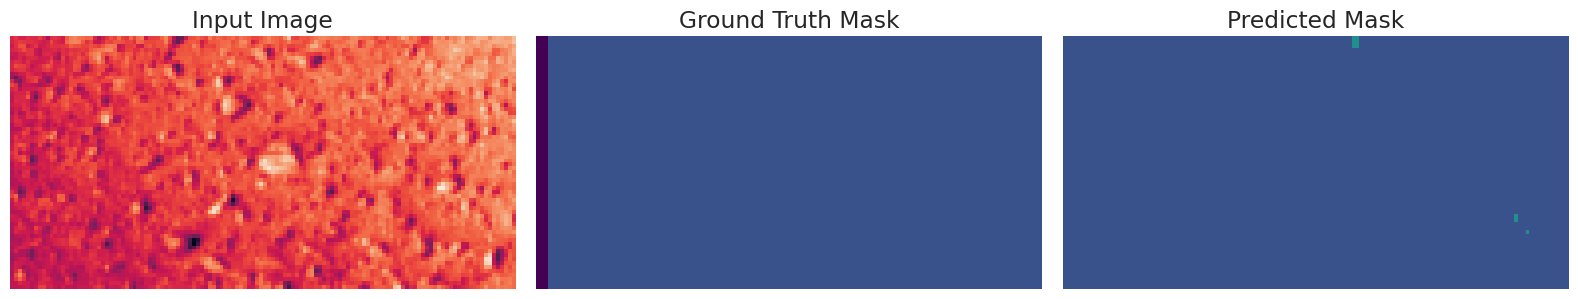

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.9384 - mean_iou: 0.4215 - sparse_categorical_crossentropy: 2.0574 - val_loss: 3.6823 - val_mean_iou: 0.3100 - val_sparse_categorical_crossentropy: 3.1787
Epoch 52/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.6697 - mean_iou: 0.4439 - sparse_categorical_crossentropy: 2.0466 - val_loss: 3.7486 - val_mean_iou: 0.2947 - val_sparse_categorical_crossentropy: 3.1519
Epoch 53/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.7033 - mean_iou: 0.4475 - sparse_categorical_crossentropy: 2.0785 - val_loss: 2.6977 - val_mean_iou: 0.2630 - val_sparse_categorical_crossentropy: 2.7972
Epoch 54/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 2.3376 - mean_iou: 0.3644 - sparse_categorical_crossentropy: 2.1355 - val_loss: 40.2492 - val_mean_iou: 0.1695 - val_sparse_categorical_crossentropy: 9.1806
Epoch 55/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.6964 - mean_iou: 0.3306 - sparse_categorical_crossentropy: 1.9728 - val

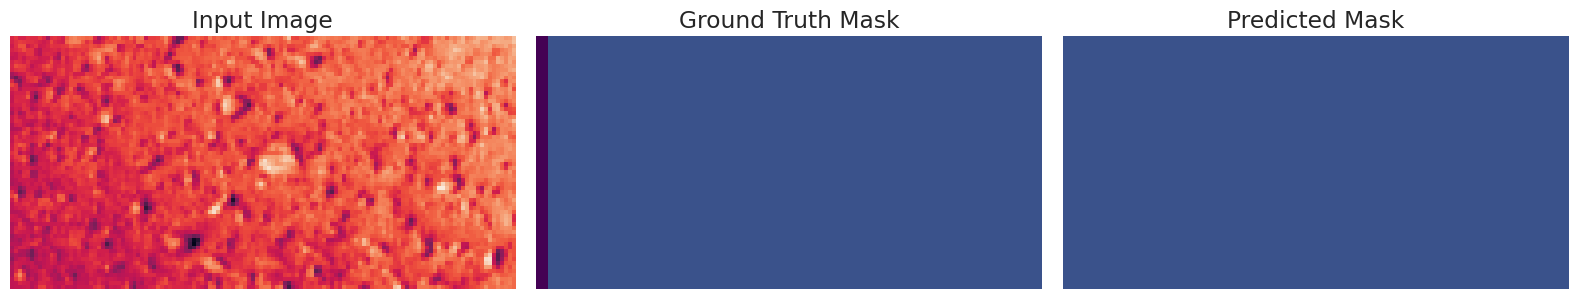

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 1.5606 - mean_iou: 0.3287 - sparse_categorical_crossentropy: 2.0290 - val_loss: 2.9818 - val_mean_iou: 0.2581 - val_sparse_categorical_crossentropy: 2.7531
Epoch 57/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.5595 - mean_iou: 0.3519 - sparse_categorical_crossentropy: 2.0436 - val_loss: 6.1647 - val_mean_iou: 0.2377 - val_sparse_categorical_crossentropy: 3.3795
Epoch 58/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.8083 - mean_iou: 0.3018 - sparse_categorical_crossentropy: 2.0617 - val_loss: 4.0578 - val_mean_iou: 0.2463 - val_sparse_categorical_crossentropy: 3.3396
Epoch 59/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.2993 - mean_iou: 0.3685 - sparse_categorical_crossentropy: 2.0646 - val_loss: 3.9670 - val_mean_iou: 0.2278 - val_sparse_categorical_crossentropy: 5.1009
Epoch 60/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 1.2542 - mean_iou: 0.3666 - sparse_categorical_crossentropy: 2.0098 - val_

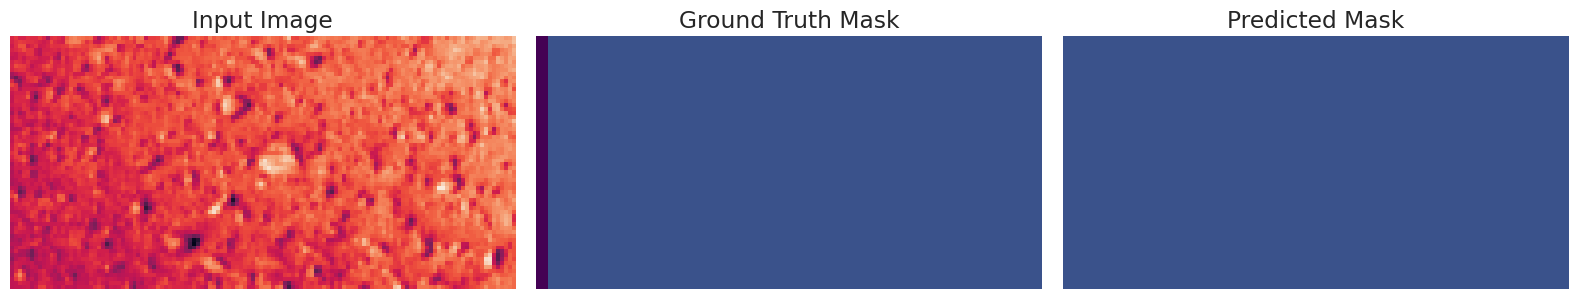

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.8278 - mean_iou: 0.4056 - sparse_categorical_crossentropy: 2.0035 - val_loss: 1.3220 - val_mean_iou: 0.3188 - val_sparse_categorical_crossentropy: 2.5602
Epoch 62/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.2655 - mean_iou: 0.4025 - sparse_categorical_crossentropy: 2.0432 - val_loss: 2.4814 - val_mean_iou: 0.2638 - val_sparse_categorical_crossentropy: 2.7070
Epoch 63/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 1.5322 - mean_iou: 0.3628 - sparse_categorical_crossentropy: 2.1101 - val_loss: 2.8668 - val_mean_iou: 0.2853 - val_sparse_categorical_crossentropy: 2.9837
Epoch 64/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.0500 - mean_iou: 0.3873 - sparse_categorical_crossentropy: 2.0878 - val_loss: 1.9632 - val_mean_iou: 0.1684 - val_sparse_categorical_crossentropy: 2.8740
Epoch 65/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.0648 - mean_iou: 0.3837 - sparse_categorical_crossentropy: 2.1182 - val_

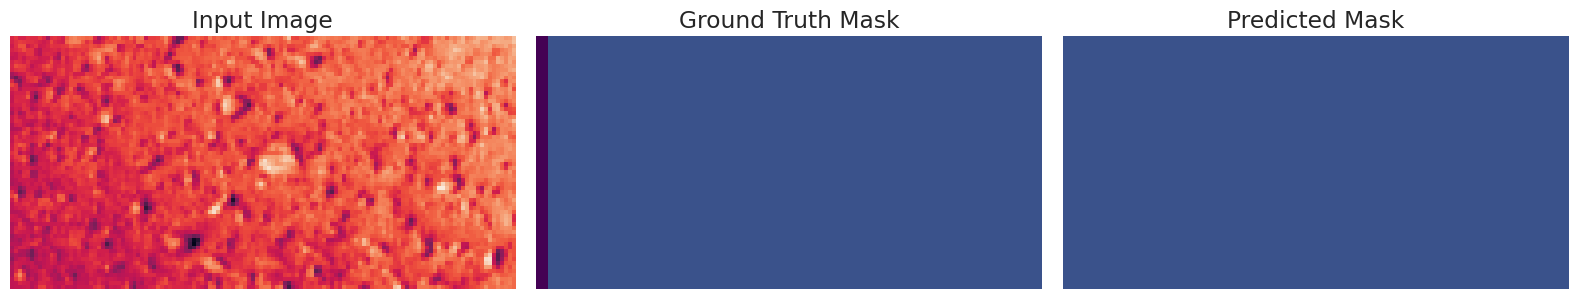

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 1.0612 - mean_iou: 0.4028 - sparse_categorical_crossentropy: 2.1100 - val_loss: 2.4363 - val_mean_iou: 0.3162 - val_sparse_categorical_crossentropy: 3.1539
Epoch 67/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.7005 - mean_iou: 0.4337 - sparse_categorical_crossentropy: 2.1107 - val_loss: 2.1390 - val_mean_iou: 0.3484 - val_sparse_categorical_crossentropy: 2.8081
Epoch 68/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.9571 - mean_iou: 0.4150 - sparse_categorical_crossentropy: 2.1542 - val_loss: 2.7914 - val_mean_iou: 0.2638 - val_sparse_categorical_crossentropy: 3.0391
Epoch 69/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.8436 - mean_iou: 0.4238 - sparse_categorical_crossentropy: 2.1753 - val_loss: 1.9545 - val_mean_iou: 0.3604 - val_sparse_categorical_crossentropy: 2.7917
Epoch 70/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.8748 - mean_iou: 0.4414 - sparse_categorical_crossentropy: 2.1462 - val_

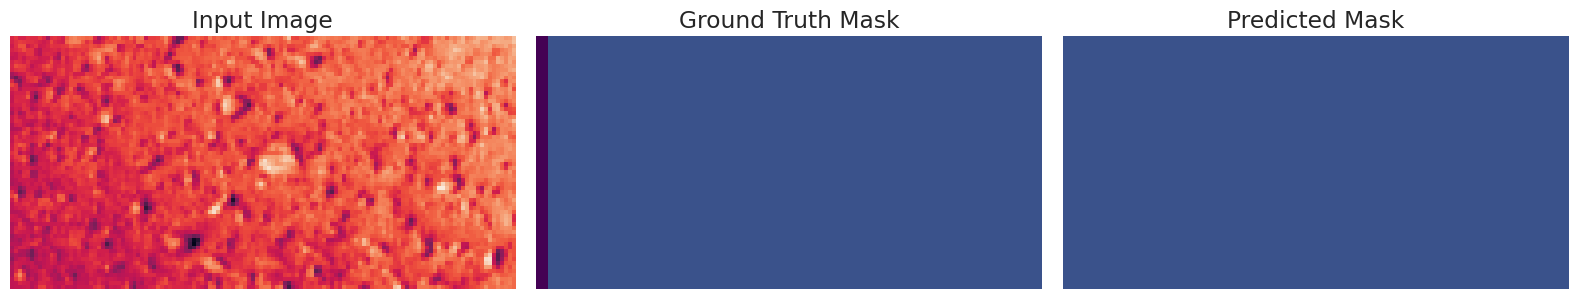

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.5842 - mean_iou: 0.4796 - sparse_categorical_crossentropy: 2.1497 - val_loss: 2.0680 - val_mean_iou: 0.3493 - val_sparse_categorical_crossentropy: 2.8817
Epoch 72/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.5430 - mean_iou: 0.4933 - sparse_categorical_crossentropy: 2.1510 - val_loss: 1.3721 - val_mean_iou: 0.3500 - val_sparse_categorical_crossentropy: 2.7568
Epoch 73/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.5494 - mean_iou: 0.4918 - sparse_categorical_crossentropy: 2.1653 - val_loss: 1.6681 - val_mean_iou: 0.3544 - val_sparse_categorical_crossentropy: 2.9004
Epoch 74/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 0.6001 - mean_iou: 0.4734 - sparse_categorical_crossentropy: 2.1821 - val_loss: 2.1994 - val_mean_iou: 0.3513 - val_sparse_categorical_crossentropy: 2.9288
Epoch 75/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 0.5563 - mean_iou: 0.4971 - sparse_categorical_crossentropy: 2.1626 - val_

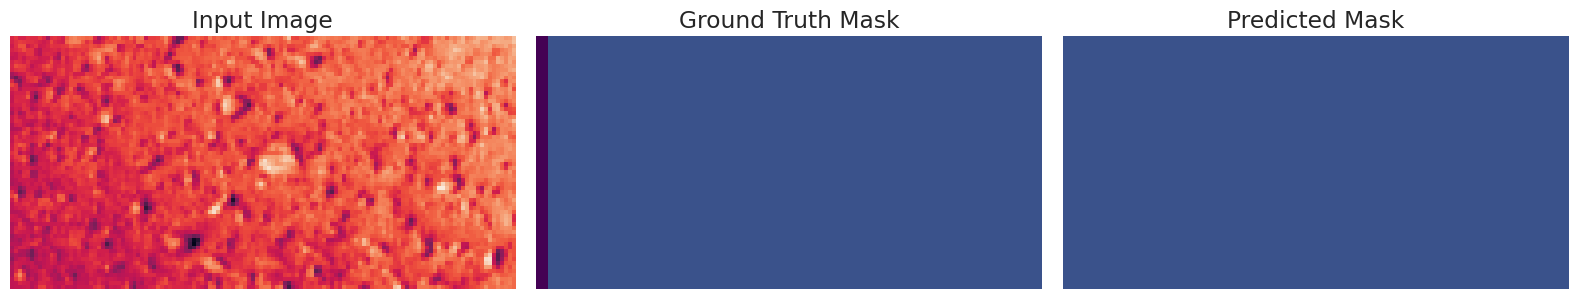

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.4296 - mean_iou: 0.5347 - sparse_categorical_crossentropy: 2.1496 - val_loss: 2.0876 - val_mean_iou: 0.3427 - val_sparse_categorical_crossentropy: 2.8580
Epoch 77/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.4411 - mean_iou: 0.5441 - sparse_categorical_crossentropy: 2.1601 - val_loss: 1.9473 - val_mean_iou: 0.3598 - val_sparse_categorical_crossentropy: 2.7449
Epoch 78/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.3846 - mean_iou: 0.5938 - sparse_categorical_crossentropy: 2.1542 - val_loss: 2.4356 - val_mean_iou: 0.3429 - val_sparse_categorical_crossentropy: 2.7744
Epoch 79/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.3514 - mean_iou: 0.6071 - sparse_categorical_crossentropy: 2.1477 - val_loss: 1.9100 - val_mean_iou: 0.3321 - val_sparse_categorical_crossentropy: 2.8501
Epoch 80/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.3839 - mean_iou: 0.5763 - sparse_categorical_crossentropy: 2.1679 - val_

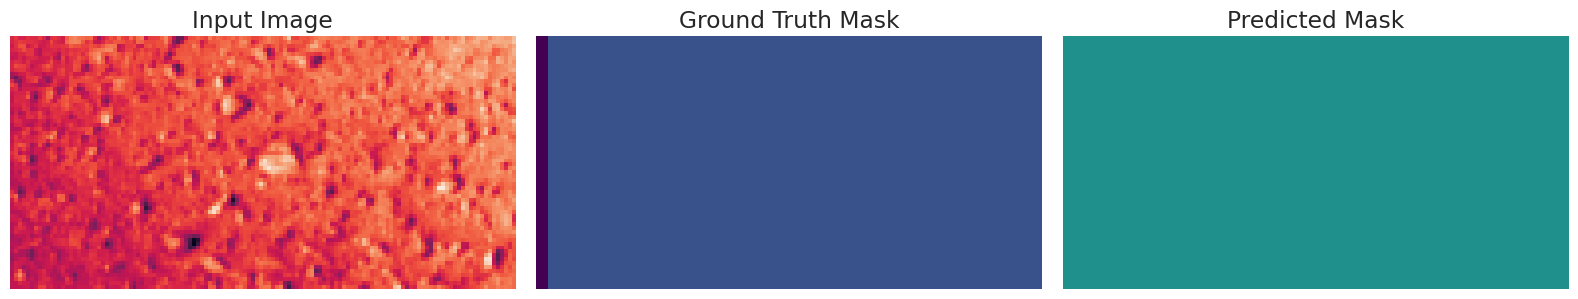

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.5897 - mean_iou: 0.4755 - sparse_categorical_crossentropy: 2.2221 - val_loss: 3.2295 - val_mean_iou: 0.2746 - val_sparse_categorical_crossentropy: 3.8569
Epoch 82/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.7058 - mean_iou: 0.4805 - sparse_categorical_crossentropy: 2.2076 - val_loss: 4.1315 - val_mean_iou: 0.2067 - val_sparse_categorical_crossentropy: 3.8280
Epoch 83/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.5158 - mean_iou: 0.5096 - sparse_categorical_crossentropy: 2.2001 - val_loss: 2.2027 - val_mean_iou: 0.3010 - val_sparse_categorical_crossentropy: 3.0463
Epoch 84/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.4352 - mean_iou: 0.5528 - sparse_categorical_crossentropy: 2.1915 - val_loss: 2.0085 - val_mean_iou: 0.3681 - val_sparse_categorical_crossentropy: 2.8639
Epoch 85/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.5526 - mean_iou: 0.5624 - sparse_categorical_crossentropy: 2.1801 - val_

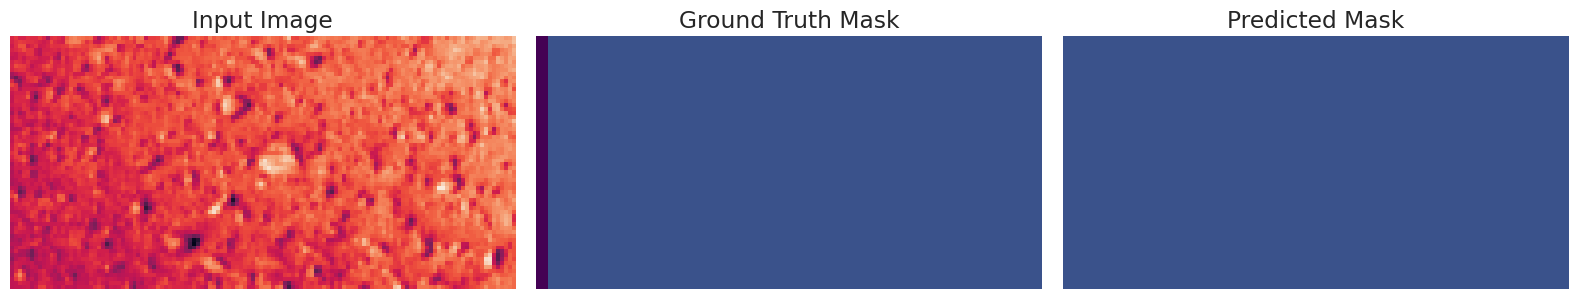

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 1.0783 - mean_iou: 0.3654 - sparse_categorical_crossentropy: 2.1256 - val_loss: 3.8572 - val_mean_iou: 0.2562 - val_sparse_categorical_crossentropy: 3.3319
Epoch 87/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.3218 - mean_iou: 0.3699 - sparse_categorical_crossentropy: 2.1535 - val_loss: 2.9793 - val_mean_iou: 0.2245 - val_sparse_categorical_crossentropy: 2.8094
Epoch 88/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.4259 - mean_iou: 0.3489 - sparse_categorical_crossentropy: 2.2367 - val_loss: 3.5239 - val_mean_iou: 0.1876 - val_sparse_categorical_crossentropy: 3.3890
Epoch 89/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.3187 - mean_iou: 0.3626 - sparse_categorical_crossentropy: 2.2509 - val_loss: 2.9153 - val_mean_iou: 0.2114 - val_sparse_categorical_crossentropy: 3.3493
Epoch 90/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.4358 - mean_iou: 0.3573 - sparse_categorical_crossentropy: 2.2751 - val_

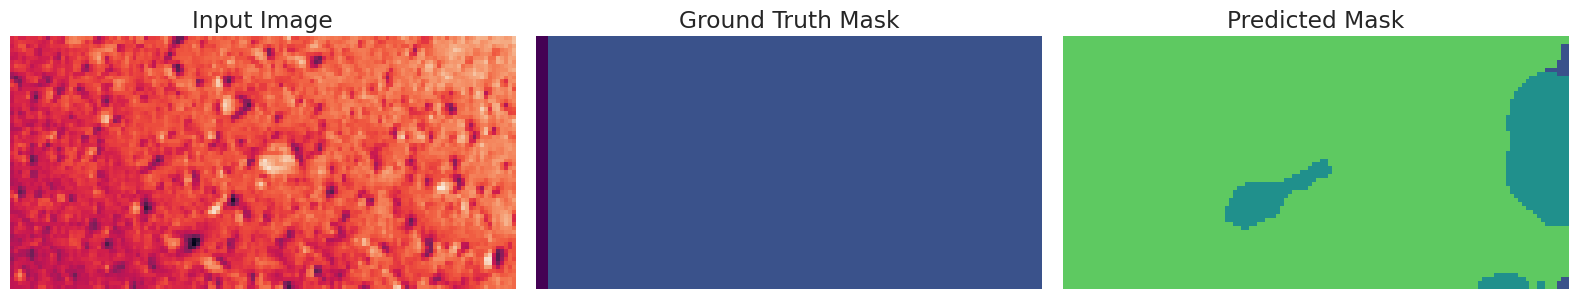

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 1.6918 - mean_iou: 0.3340 - sparse_categorical_crossentropy: 2.2981 - val_loss: 4.5516 - val_mean_iou: 0.1918 - val_sparse_categorical_crossentropy: 4.0025
Epoch 92/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.3001 - mean_iou: 0.3640 - sparse_categorical_crossentropy: 2.2721 - val_loss: 3.4504 - val_mean_iou: 0.2665 - val_sparse_categorical_crossentropy: 3.5392
Epoch 93/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.1071 - mean_iou: 0.3969 - sparse_categorical_crossentropy: 2.2982 - val_loss: 2.2614 - val_mean_iou: 0.2868 - val_sparse_categorical_crossentropy: 3.2035
Epoch 94/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.9500 - mean_iou: 0.4187 - sparse_categorical_crossentropy: 2.3087 - val_loss: 2.1668 - val_mean_iou: 0.2902 - val_sparse_categorical_crossentropy: 3.3013
Epoch 95/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 1.0943 - mean_iou: 0.4244 - sparse_categorical_crossentropy: 2.3286 - val_

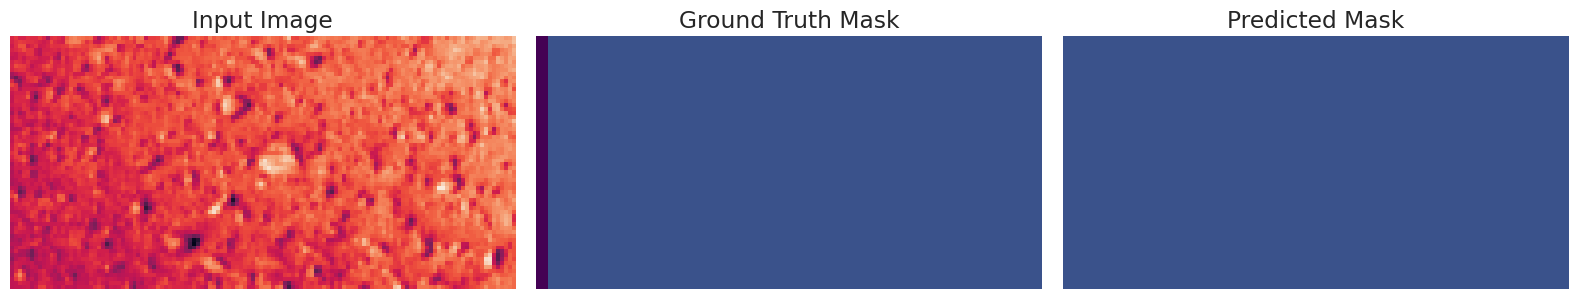

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.8705 - mean_iou: 0.4297 - sparse_categorical_crossentropy: 2.3241 - val_loss: 2.4577 - val_mean_iou: 0.3200 - val_sparse_categorical_crossentropy: 3.2044
Epoch 97/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 1.2212 - mean_iou: 0.4191 - sparse_categorical_crossentropy: 2.3440 - val_loss: 2.4965 - val_mean_iou: 0.3116 - val_sparse_categorical_crossentropy: 3.3496
Epoch 98/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - loss: 0.7715 - mean_iou: 0.4634 - sparse_categorical_crossentropy: 2.3297 - val_loss: 2.5242 - val_mean_iou: 0.3505 - val_sparse_categorical_crossentropy: 3.3365
Epoch 99/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.5992 - mean_iou: 0.4869 - sparse_categorical_crossentropy: 2.3276 - val_loss: 2.5406 - val_mean_iou: 0.3353 - val_sparse_categorical_crossentropy: 3.4386
Epoch 100/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.5671 - mean_iou: 0.5010 - sparse_categorical_crossentropy: 2.3498 - val

In [65]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[
        early_stopping,
        viz_callback,
    ],
    verbose=1,
).history

In [66]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 36.81%


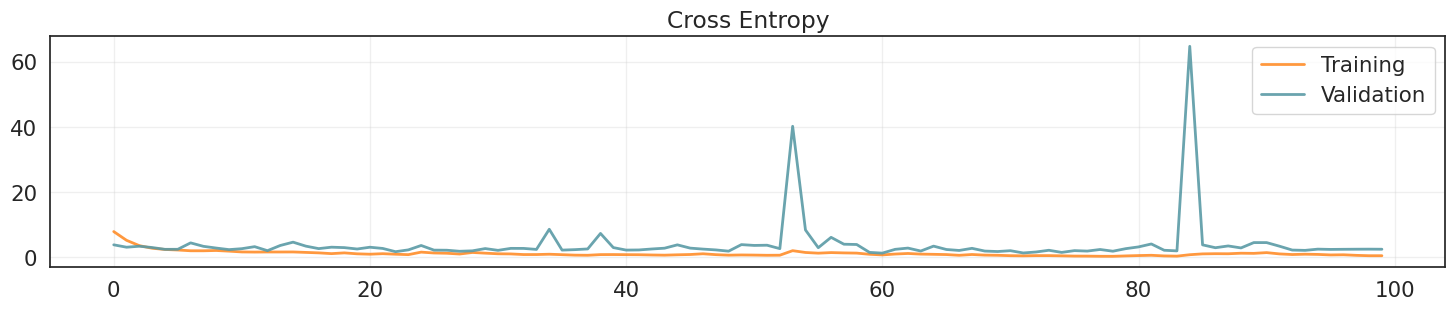

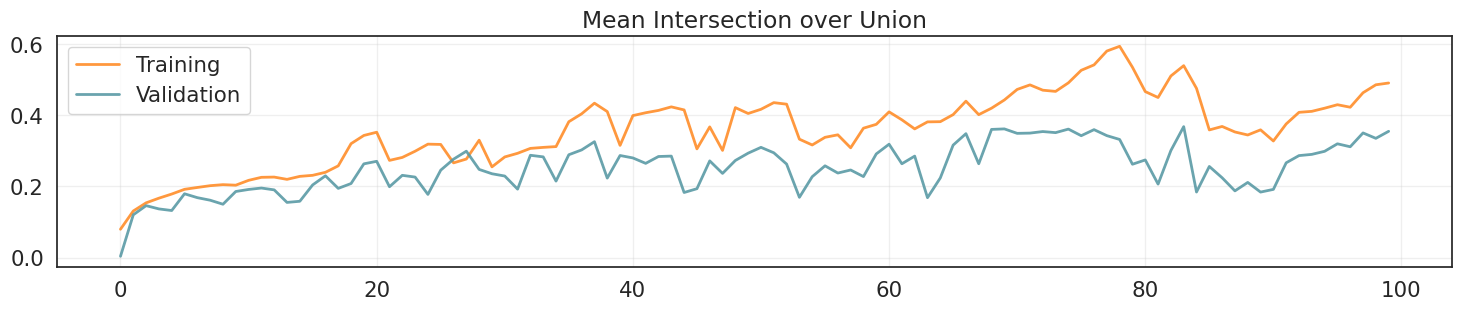

In [67]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Model Submission

In [72]:
model_filename="UNet_36.81.keras"

In [73]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [74]:
from tensorflow.keras.utils import get_custom_objects

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None, ignore_class=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0. We want to exclude some classes we dont care
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

    @classmethod
    def from_config(cls, config):
        # Handle unexpected arguments like 'sparse_y_true' and 'sparse_y_pred'
        config.pop('sparse_y_true', None)
        config.pop('sparse_y_pred', None)
        config.pop('axis', None)

        # Ensure the 'ignore_class' argument is handled correctly
        config = {**config, 'labels_to_exclude': config.get('ignore_class', [0])}
        return cls(**config)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

get_custom_objects().update({'MeanIntersectionOverUnion': MeanIntersectionOverUnion})

In [75]:
tf.keras.config.enable_unsafe_deserialization()
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_36.81.keras


In [77]:
# Percorso del dataset
data_path = "mars_for_students.npz"

# Caricamento del dataset
data = np.load(data_path, allow_pickle=True)

# Estrarre i dati di testing
X_test = data["test_set"]

print(f"Dimensioni X_test: {X_test.shape}")

Dimensioni X_test: (10022, 64, 128)


In [79]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step
Predictions shape: (10022, 64, 128)


In [84]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [85]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"{timestep_str}.csv"
submission_df = y_to_df(preds)

# Save to CSV (Kaggle environment will store the file in the kernel output directory)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved as: {submission_filename}")

Submission file saved as: UNet_36.81.csv
